In [29]:
#Bibliotecas
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
#from scipy.fft import dct as scipy_dct
from scipy.fftpack import dct as scipy_dct
from scipy.fftpack import idct as scipy_idct

In [ ]:
def huffman(data):
    N = c.size
    q = priority_queue()

    for i = 1 to N
        n = node(c[i])
        q.push(n)
    end for

    while q.size is not equal to 1
        z = node()
        z.left = x = q.pop()
        z.right = y = q.pop()
        z.frequency = x.frequency + y.frequency
        q.push(z)
    end while

    return q

In [30]:
def rle_decode(data):
    output = []
    is_repeat = True
    for value in data:
        if is_repeat:
            repeat = value
        else:
            for _ in range(repeat):
                output.append(value)

        is_repeat = not is_repeat

    return output

In [31]:
def rle_encode(data):
    # Lista normal do Python. Veja aula 2.
    encoding = []
    if data.size == 0:
        # Retorne nada se estiver vazio:
        return encoding
    
    prev = data[0]
    count = 0
    
    for value in data:
        if value != prev:
            # Se o valor atual for diferente dos anteriores,
            # adiciona a contagem e o pixel anterior na nova
            # linha:
            encoding.append(count)
            encoding.append(prev)
                
            count = 1
            prev = value
        else:
            # Se for igual ao valor anterior, incrementa a
            # contagem:
            count += 1
            
    # Adiciona o último valor e sua contagem:
    encoding.append(count)
    encoding.append(prev)
    return encoding

In [32]:
def quantization(img, delta=10):
    img_quantized = delta * np.floor(img / delta + 0.5)
    
    return img_quantized

In [33]:
def reverse_quantization(img, delta=10):
    img_quantized = delta * np.floor(img / delta + 0.5)
    
    return img_quantized

In [34]:
def dct(img):
    N1, N2 = img.shape
    dct = np.zeros(shape = img.shape)
    
    for k1 in range(N1): 
        if k1 == 0:
            a1 = 1 / np.sqrt(N1)
        else:
            a1 = np.sqrt(2 / N1)

        for k2 in range(N2): 
            sum_n1 = 0
            for n1 in range(N1):
                sum_n2 = 0
    
                for n2 in range(N2):
                    x = img[n1, n2]
                    sum_n2 += x * np.cos(np.pi / N2 * (n2 + 0.5) * k2)

                sum_n1 += sum_n2 * np.cos(np.pi / N1 * (n1 + 0.5) * k1)

            if k2 == 0:
                a2 = 1 / np.sqrt(N2)
            else:
                a2 = np.sqrt(2 / N2)

            dct[k1, k2] = sum_n1 * a1 * a2

    return dct

In [35]:
def idct(img):
    N1, N2 = img.shape
    idct = np.zeros(shape=img.shape)
    for n1 in range(N1): # for i in range(l)
        for n2 in range(N2): # for j in range(c)
            sum_k1 = 0

            for k1 in range(N1):
                if k1 == 0:
                    a1 = 1 / np.sqrt(N1)
                else:
                    a1 = np.sqrt(2 / N1)

                sum_k2 = 0
                for k2 in range(N2):
                    if k2 == 0:
                        a2 = 1 / np.sqrt(N2)
                    else:
                        a2 = np.sqrt(2 / N2)

                    x = img[k1, k2]
                    sum_k2 += x * np.cos(np.pi / N2 * (n2 + 0.5) * k2) * a2

                sum_k1 += sum_k2 * np.cos(np.pi / N1 * (n1 + 0.5) * k1) * a1

            idct[n1, n2] = sum_k1

    return idct

In [36]:
def luminosity_grayscale(img):
    (l, c, p) = img.shape
    gray = np.zeros(shape = (l, c), dtype = np.uint8)
    
    for i in range(l):
        for j in range(c):
            r = float(img[i, j, 0])
            g = float(img[i, j, 1])
            b = float(img[i, j, 2])
            
            gray[i, j] = 0.2126 * r + 0.7152 * g + 0.0722 * b
            
    return gray

In [37]:
def convert_yCbCr_rgb(img):
    (l, c, p) = img.shape
    img_rgb = np.zeros(shape = (l, c, p), dtype = np.uint8)
    
    for i in range(l):
        for j in range(c):
            y = img[i, j, 0]
            cb = img[i, j, 1]
            cr = img[i, j, 2]
            
            r = 1.164 * (y - 16) + 1.596 * (cr - 128)
            g = 1.164 * (y - 16) - 0.392 * (cb - 128) - 0.813 * (cr - 128)
            b = 1.164 * (y - 16) + 2.017 * (cb - 128)
            
            r = np.clip(r, 0, 255)
            g = np.clip(g, 0, 255)
            b = np.clip(b, 0, 255)
            
            img_rgb[i, j, 0] = r
            img_rgb[i, j, 1] = g
            img_rgb[i, j, 2] = b
            
    return img_rgb

In [38]:
def chroma_subsampling(img_y, img_Cb, img_Cr):
    (l, c, p) = img_y.shape
    img_subsampling = img_y
    
    for i in range(l):
        for j in range(0, c, 2):
            img_subsampling[i, j, 1] = img_Cb[i, j, 1]
            img_subsampling[i, j + 1, 1] = img_Cb[i, j, 1]
            
            img_subsampling[i, j, 2] = img_Cr[i, j, 2]
            img_subsampling[i, j + 1, 2] = img_Cr[i, j, 2]
    
    return img_subsampling

In [39]:
def convert_rgb_yCbCr(img):
    (l, c, p) = img.shape
    img_yCbCr = np.zeros(shape = (l, c, 3), dtype = np.uint8)
    
    img_y = np.zeros(shape = (l, c, 3), dtype = np.uint8)
    img_Cb = np.zeros(shape = (l, c, 3), dtype = np.uint8)
    img_Cr = np.zeros(shape = (l, c, 3), dtype = np.uint8)
    
    for i in range(l):
        for j in range(c):
            r = img[i, j, 0]
            g = img[i, j, 1]
            b = img[i, j, 2]
            
            y = 0.257 * r + 0.505 * g + 0.098 * b + 16  #0.504?
            y = np.clip(y, 16, 235)
            
            cb = -0.148 * r - 0.291 * g + 0.439 * b + 128
            cb = np.clip(cb, 16, 240)
            
            cr = 0.439 * r - 0.368 * g - 0.071 * b + 128
            cr = np.clip(cr, 16, 240)
            
            img_y[i, j] = y
            
            img_Cb[i, j] = cb
            
            img_Cr[i, j] = cr
            
            img_yCbCr[i, j, 0] = y
            img_yCbCr[i, j, 1] = cb
            img_yCbCr[i, j, 2] = cr
            
    return img_yCbCr, img_y, img_Cb, img_Cr

In [40]:
img_name = 'naruto.png'
img_new_name = img_name[:-4]+'_new.jpg'

In [41]:
# Abrindo imagem
img = np.array(Image.open(img_name))
# Conversão escala de cores
(img_yCbCr, img_y, img_Cb, img_Cr) = convert_rgb_yCbCr(img)

# Subamostragem de cor
img_subsampling = chroma_subsampling(img_y, img_Cb, img_Cr)

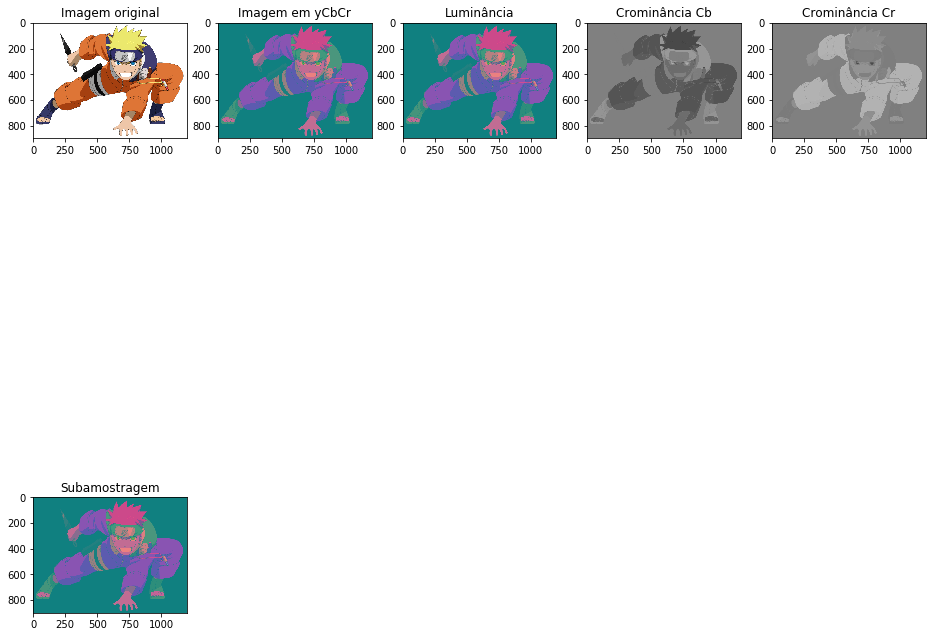

In [42]:
# Exibindo imagens

plt.figure(figsize = (16, 16))

plt.subplot(2, 5, 1)
plt.title('Imagem original')
plt.imshow(img)

plt.subplot(2, 5, 2)
plt.title('Imagem em yCbCr')
plt.imshow(img_yCbCr)

plt.subplot(2, 5, 3)
plt.title('Luminância')
plt.imshow(img_y)

plt.subplot(2, 5, 4)
plt.title('Crominância Cb')
plt.imshow(img_Cb)

plt.subplot(2, 5, 5)
plt.title('Crominância Cr')
plt.imshow(img_Cr)

plt.subplot(2, 5, 6)
plt.title('Subamostragem')
plt.imshow(img_subsampling)

In [43]:
# Subamostragem de cada camada de cor
img_0 = img_subsampling[:, :, 0]
img_1 = img_subsampling[:, :, 1]
img_2 = img_subsampling[:, :, 2]

# Deslocar em 128 para esquerda
(l, c) = img_0.shape
for i in range(l):
    for j in range(c):
        img_0[i, j] -= 128
        img_1[i, j] -= 128
        img_2[i, j] -= 128

In [44]:
# DCT
img_dct_0 = scipy_dct(scipy_dct(img_0.T, norm='ortho').T, norm='ortho')
img_dct_1 = scipy_dct(scipy_dct(img_1.T, norm='ortho').T, norm='ortho')
img_dct_2 = scipy_dct(scipy_dct(img_2.T, norm='ortho').T, norm='ortho')

In [45]:
# Quantização
img_quantized_0 = np.zeros(shape = img_dct_0.shape)
img_quantized_1 = np.zeros(shape = img_dct_0.shape)
img_quantized_2 = np.zeros(shape = img_dct_0.shape)

img_quantized_0 = quantization(img_dct_0)
img_quantized_1 = quantization(img_dct_1)
img_quantized_2 = quantization(img_dct_2)

In [ ]:
# RLE_Encode
img_encoded_0 = rle_encode(img_quantized_0.flatten())
img_encoded_1 = rle_encode(img_quantized_1.flatten())
img_encoded_2 = rle_encode(img_quantized_2.flatten())

# Paramos aqui

Fazer RLE e em seguida Huffman

<BarContainer object of 256 artists>

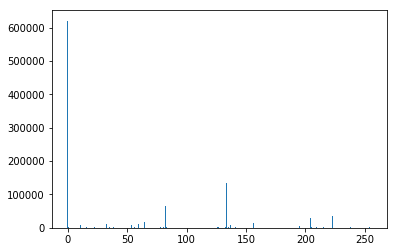

In [81]:
def histogram(img):
    (l, c) = img.shape
    h = np.zeros(shape=256, dtype=np.int32)
    for i in range(l):
        for j in range(c):
            intensity = img[i, j]
            h[intensity] += 1
            
    return h

def histogram3(img):
    hr = histogram(img[:, :, 0])
    hg = histogram(img[:, :, 1])
    hb = histogram(img[:, :, 2])
    return (hr, hg, hb)

img_gray = luminosity_grayscale(img)
hist = histogram(img_gray)
plt.bar(range(256), histogram(img_gray))

<BarContainer object of 256 artists>

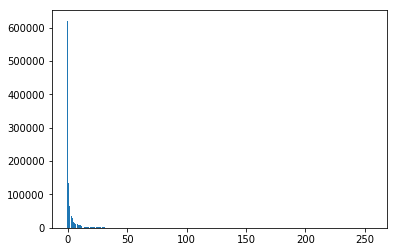

In [85]:
# Huffman 
# [::-1] inverte o array, de forma a termos
# ele ordenado de maior para menor:
hist_sorted_indexes = np.argsort(hist)[::-1]
# O mesmo que np.sort(hist)[::-1]:
hist_sorted = hist[hist_sorted_indexes]

# Devemos remover os elementos cuja probabilidade é nula:
# Os índices serão filtrados por aqueles cuja
# probabilidade associada não é nula:
indexes = hist_sorted_indexes[hist_sorted > 0]
probs = hist[indexes] / img.size

probabilities = np.zeros(shape=(indexes.size, 2))
probabilities[:, 0] = indexes
probabilities[:, 1] = probs

plt.bar(range(256), hist_sorted)

In [47]:
# RLE_Decode
img_decoded_0 = np.reshape(rle_decode(img_encoded_0), (l, c))
img_decoded_1 = np.reshape(rle_decode(img_encoded_1), (l, c))
img_decoded_2 = np.reshape(rle_decode(img_encoded_2), (l, c))

In [48]:
# Desquantização
img_reverse_quantized_0 = np.zeros(shape = img_decoded_0.shape)
img_reverse_quantized_1 = np.zeros(shape = img_decoded_0.shape)
img_reverse_quantized_2 = np.zeros(shape = img_decoded_0.shape)

img_reverse_quantized_0 = reverse_quantization(img_decoded_0)
img_reverse_quantized_1 = reverse_quantization(img_decoded_1)
img_reverse_quantized_2 = reverse_quantization(img_decoded_2)

In [49]:
# IDCT
l, c = img_reverse_quantized_0.shape

img_idct_0 = scipy_idct(scipy_idct(img_reverse_quantized_0.T, norm='ortho').T, norm='ortho')
img_idct_1 = scipy_idct(scipy_idct(img_reverse_quantized_1.T, norm='ortho').T, norm='ortho')
img_idct_2 = scipy_idct(scipy_idct(img_reverse_quantized_2.T, norm='ortho').T, norm='ortho')

In [50]:
# Deslocar em 128 para direita
l, c = img_idct_0.shape

almost_there_0 = np.zeros(shape=(l, c))
almost_there_1 = np.zeros(shape=(l, c))
almost_there_2 = np.zeros(shape=(l, c))

for i in range(l):
    for j in range(c):
        almost_there_0[i, j] = img_idct_0[i, j] + 128
        almost_there_1[i, j] = img_idct_1[i, j] + 128
        almost_there_2[i, j] = img_idct_2[i, j] + 128

In [51]:
# Juntando as camadas de cores
finally_jpeg_image = np.zeros(shape = (l, c, 3), dtype=np.uint8)
finally_jpeg_image[:, :, 0] = almost_there_0
finally_jpeg_image[:, :, 1] = almost_there_1
finally_jpeg_image[:, :, 2] = almost_there_2

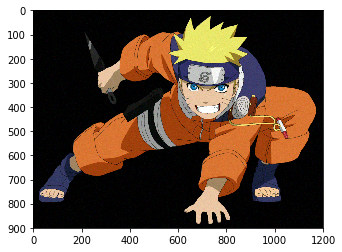

In [52]:
# Convertendo cores yCbCr para RGB
finally_jpeg_image = convert_yCbCr_rgb(finally_jpeg_image)
plt.imshow(finally_jpeg_image)

In [53]:
# Salvando a imagem nova
img_pil = Image.fromarray(finally_jpeg_image)
img_pil.save(img_new_name)

In [56]:
img_compressed = np.array(Image.open(img_new_name))

print('tamanho em bytes img original: ',img.nbytes)
print('tamanho em bytes img comprimida: ',img_compressed.nbytes)
print('taxa de compressão: ',img.nbytes/img_compressed.nbytes)

tamanho em bytes img original:  4320000
tamanho em bytes img comprimida:  3240000
taxa de compressão:  1.3333333333333333


In [55]:
#https://web.archive.org/web/20180421030430/http://www.equasys.de/colorconversion.html